In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
#TODO: implement chi-squared option for categorical-vs-categorical
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

import sys
sys.path.insert(0, "../src/ppscore")
from calculation import score, matrix, predictors

In [4]:
size = 10000
x0 = np.random.randn(size)
x1 = np.random.lognormal(2,2,size)
x2 = x1*x0# + np.random.lognormal(size = size)
x3 = x1 + x0# + np.random.lognormal(size = size)
c0 = np.random.randint(0,9, size = size)
c1 = np.random.randint(0,9, size = size)
c2 = c1.copy()
c2[:size//2] = np.random.choice(c2[:size//2], size = len(c2[:size//2]),)
c0[0] = 100

In [120]:
data = pd.DataFrame({
    "x0":np.where(x0 > 1, np.nan, x0),
    "x1":x1,
    "x2":x2,
    "x3":x3,
    "c0":c0.astype(str),
    "c1":c1.astype(str),
    "c2":c2.astype(str),
    "weights":np.random.random(len(c2))
})

In [121]:
import warnings
warnings.filterwarnings(action="ignore")

In [126]:

results  = matrix(data, conditional = "c0", catch_errors = False, n_bins_y=10, verbose = False, n_jobs_cv = 1, n_jobs = -1, )
mx = results.pivot(index = "x", columns = "y", values = "average_score")

<AxesSubplot: xlabel='y', ylabel='x'>

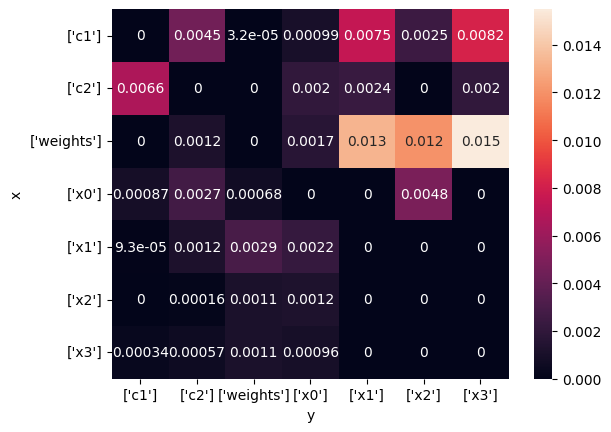

In [127]:
sns.heatmap(mx,annot = True)

In [110]:
import sklearn
sklearn.__version__

'1.1.2'

In [111]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

model = RandomForestClassifier(n_estimators=10, min_samples_leaf=2)

cv = TimeSeriesSplit()

results  = predictors(data, "x1", sample_weight = "weights",  conditional = "x3", model=model, catch_errors = False, n_bins_target=10, n_bins_independent = 30, dropna = None, verbose = True, cross_validation=cv, n_jobs = -1)
mx = results.pivot(index = "x", columns = "y", values = "ppscore")

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4950.78it/s]


In [112]:
#TODO: set option for normalized or unormalized score, or bring both in output

In [113]:

results


,x,y,conditional,ppscore,unnormalized_ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,x2,x1,[x3],0.607296,0.027980,regression,True,weighted AUC,0.953926,0.981907,"RandomForestClassifier(min_samples_leaf=2, n_e..."
1,x0,x1,[x3],0.578131,0.026637,regression,True,weighted AUC,0.953926,0.980563,"RandomForestClassifier(min_samples_leaf=2, n_e..."
2,c2,x1,[x3],0.000000,0.000000,regression,True,weighted AUC,0.953926,0.950402,"RandomForestClassifier(min_samples_leaf=2, n_e..."
3,c1,x1,[x3],0.000000,0.000000,regression,True,weighted AUC,0.954055,0.950797,"RandomForestClassifier(min_samples_leaf=2, n_e..."
4,c0,x1,[x3],0.000000,0.000000,regression,True,weighted AUC,0.954055,0.949674,"RandomForestClassifier(min_samples_leaf=2, n_e..."


<AxesSubplot: xlabel='y', ylabel='x'>

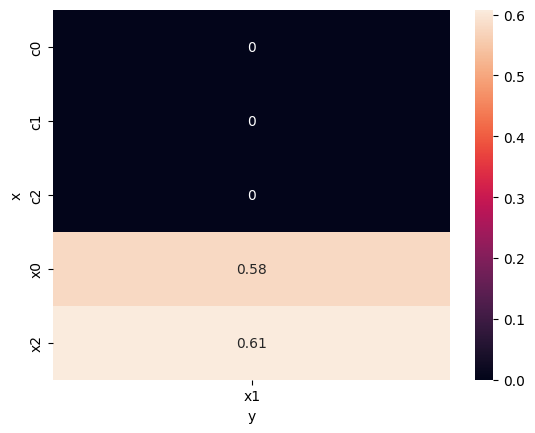

In [114]:
sns.heatmap(mx,annot = True)

# Conditional Dependence

In [79]:
n = 10_000
x0 = np.random.uniform(-5,5,n)
x1 = np.random.uniform(-5,5,n)
y = np.zeros(n)
y = np.where(np.isclose(x0, x1, atol=5e-1, equal_nan=False), 1, y)
y = np.where(np.isclose(x0, -x1, atol=5e-1, equal_nan=False), 1, y)


In [80]:
cond_data = pd.DataFrame({
    "x0":x0.flatten(),
    "x1":x1.flatten(),
    "y":y.flatten(),
})

<AxesSubplot: xlabel='x0', ylabel='x1'>

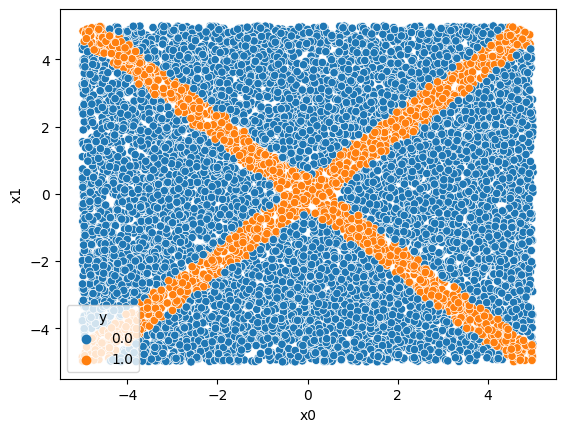

In [81]:
# x0 and x1 are only associated through y
# x0 and x1 association is bimodal, such that a simple regressor would not identify
sns.scatterplot(data = cond_data, x = "x0",y = "x1", hue = "y")

<AxesSubplot: xlabel='x0', ylabel='Density'>

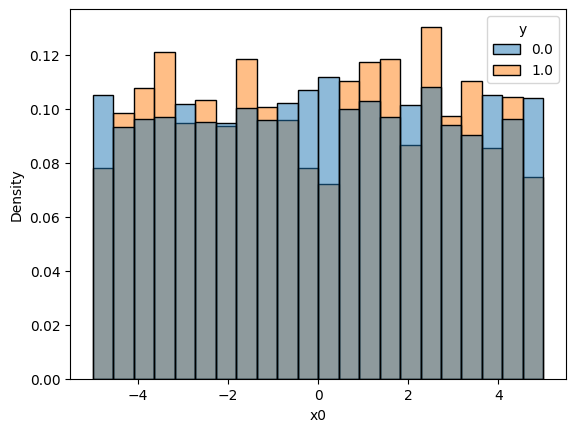

In [82]:
sns.histplot(data = cond_data, x="x0", hue = "y", stat = 'density', common_norm = False)

In [94]:
cond_results  = matrix(cond_data, conditional = "y", catch_errors = False, n_bins_target = 10,n_bins_independent=30, average = "weighted", n_jobs = -1)
results  = matrix(cond_data.drop(columns = ["y"]), conditional = None, catch_errors = False)
forest_cond_results  = matrix(cond_data, conditional = "y", catch_errors = False, model=model)

mx = results.pivot(index = "x", columns = "y", values = "ppscore")
mx_cond = cond_results.pivot(index = "x", columns = "y", values = "ppscore")
mx_forest_cond = forest_cond_results.pivot(index = "x", columns = "y", values = "ppscore")

Text(0.5, 1.0, 'unconditional dependence')

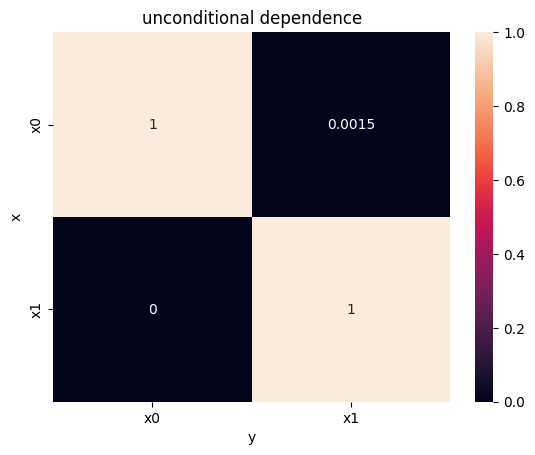

In [95]:
ax = sns.heatmap(mx,annot = True)
ax.set_title("unconditional dependence")

Text(0.5, 1.0, 'conditional dependence')

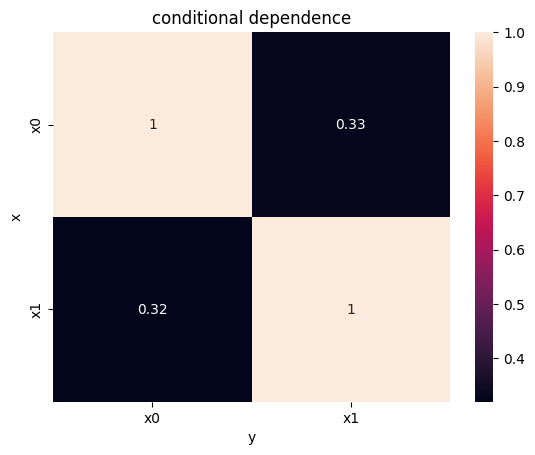

In [96]:
ax = sns.heatmap(mx_cond,annot = True)
ax.set_title("conditional dependence")

  0%|                                                     | 0/5 [08:15<?, ?it/s]


Text(0.5, 1.0, 'conditional dependence with RandomForest estimator')

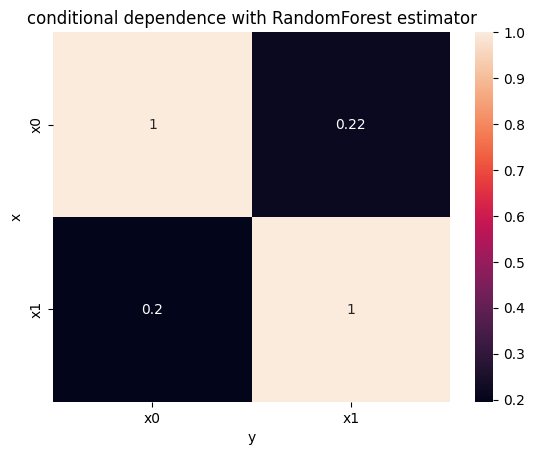

In [97]:
ax = sns.heatmap(mx_forest_cond,annot = True)
ax.set_title("conditional dependence with RandomForest estimator")

([], [], [1], [2])